> credits: originally by Gael Varoquaux
> 
> adapted by: Chris Holdgraf

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pylab as plt
import os.path as op
path_data = op.expanduser('~/data_ucsf/machine_learning')
%matplotlib inline

# About this tutorial
This is a quick introduction to doing neuroimaging machine learning with `nilearn`. It covers the following topics:

* Loading a neuroimaging dataset suitable for decoding
* Extracting an ROI and vectorizing our 3D data so it may be passed to a `sklearn` object
* Using pandas to munge some data
* Fitting a `sklearn` classifier on our neuroimaging data
* Visualizing classifier weights on the subject's brain

Note: A lot of the material in this tutorial is drawn from the `nilearn` collection of examples. Open-source packages can be a great way to learn both about a package, and about the things that package tries to do (e.g., machine learning).

In addition, many `nilearn` developers have recently released a paper covering the topics of decoding brain states with fMRI (and other modalities).

* [Link to original `nilearn` tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#sphx-glr-auto-examples-plot-decoding-tutorial-py)
* [Link to Varoquaux decoding paper](https://arxiv.org/pdf/1606.05201v2.pdf)

# A introduction tutorial to fMRI decoding
Thus far we've covered the general topics of machine learning, but how do they apply specifically to neuroscience data? There are many packages that have been designed to leverage the power of machine learning for the specific problems we attempt to solve in neuroscience. One excellent package is called `nilearn`, which focuses on neuroimaging.

This is a simple tutorial on decoding with nilearn. It reproduces the
Haxby 2001 study on a face vs cat discrimination task in a mask of the
ventral stream. We'll cover some basics of how to represent neuroimaging data in python, as well as some high-level functions that allow you to decode experimental conditions with this data.

* [Here's a link](http://www.pymvpa.org/datadb/haxby2001.html) to the Haxby 2001 Dataset (w/ a link to the paper too)

# Preparing the data

## Retrieve and load the fMRI data from the Haxby study

The `nilearn.datasets.fetch_haxby` function will download the
Haxby dataset if it's not present on the disk. It'll put this in the `nilearn` data directory and only needs to be downloaded once.

In [2]:
from nilearn import datasets
from nilearn import plotting

# By default the 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby(data_dir=path_data)
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      fmri_filename)  # 4D data

First subject functional nifti images (4D) are at: /Users/choldgraf/data_ucsf/machine_learning/haxby2001/subj1/bold.nii.gz


## Preparing the fMRI volume for model fitting
As we saw in the previous lecture, we can easily load volume data into python using `nibabel`. However, we generally don't want the full volume, but instead prefer to use a subset of voxels based on some preferred region of the brain (e.g. the cortical surface).

Effectively, we wish to do two things:

1. Extract a subset of voxels from the nifty file (masking)
2. Reshape these voxels so that they can be used to fit a model (vectorizing)

`nilearn` allows us to do this easily, turning the 4-D matrix of into an array of shape (n_samples, n_features). This allows us to use scikit-learn to do machine learning.

## Masking / vectorizing our data
We will use the `nilearn.input_data.NiftiMasker` to extract the
fMRI data on a mask and convert it to data series.

First, remember that masks are simply a 3D array in the same space as our MRI data. They are basically boolean values that say whether or not to keep each voxel. 

We'll load and plot it below. The mask is a mask of the Ventral Temporal streaming area coming from the Haxby study:

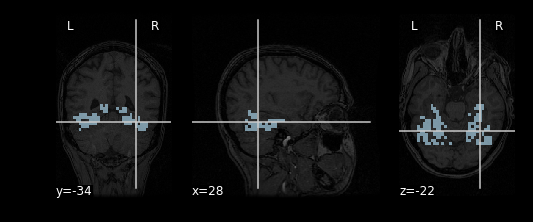

In [3]:
mask_filename = haxby_dataset.mask_vt[0]
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')

Notice that only a few of the voxels are being shown here. These are the voxels that the mask has extracted. Now we use the NiftiMasker.

We first create a masker, giving it the options that we care
about. Here we also use standardizing of the data, as it is often important
for decoding. This scales the data so that its mean / variance is more consistent across voxels.

In [4]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_filename, standardize=True)
masker

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img='/Users/choldgraf/data_ucsf/machine_learning/haxby2001/subj1/mask4_vt.nii.gz',
      mask_strategy='background', memory=Memory(cachedir=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

**A note on transformers**

The `masker` is an object that can perform data masking for us. It follows a very similar API to `scikit-learn`. Objects that transform other objects are called `transformers`, and generally have a `transform` method on top of the `fit` method that we covered earlier.

We'll `fit` the masker on our mask, then use it to vectorize our data.

In [5]:
# Fitting the transformer initializes it to operate on new data
masker.fit(fmri_filename)

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img='/Users/choldgraf/data_ucsf/machine_learning/haxby2001/subj1/mask4_vt.nii.gz',
      mask_strategy='background', memory=Memory(cachedir=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

In [6]:
# Now we'll transform our fMRI data
fmri_masked = masker.transform(fmri_filename)

The variable "fmri_masked" is a numpy array. It is 2-D.

In [7]:
print(fmri_masked)

[[-2.25146627  1.11008501 -0.38940424 ..., -1.31005859 -0.82755452
   1.04562497]
 [-1.99929178  0.90351063 -0.78263468 ..., -1.76820636 -0.66073179
  -0.30779985]
 [-1.72771943  0.8471722  -0.71709627 ..., -1.16538048 -1.11570287
   0.35240737]
 ..., 
 [ 0.28967512 -1.70683813 -2.66686344 ...,  1.28209257  1.0074954
   1.24368715]
 [ 0.75522774 -1.61294067 -2.8307097  ...,  1.71612716  1.37147236
   1.07863522]
 [ 0.17328696 -1.59416115 -2.71601725 ...,  1.58350551  1.56862628
   1.57379067]]


Its shape corresponds to the number of time-points x the number of
voxels in the mask. Note that this is much fewer than the total number of voxels in the nifty image.

In [8]:
print(fmri_masked.shape)

(1452, 577)


## Load the behavioral labels

Now that we have our vectorized fMRI activity, we need labels for the state of the experiment in order to fit our classifier. The behavioral labels are stored in a CSV file, separated by spaces.

We use `pandas` to load them in an array. This is a library that is excellent for representing and manipulating tabular data. It's got a steep learning curve but is very powerful.

In [9]:
import pandas as pd
import numpy as np

# Load target information as string and give a numerical identifier to each
labels = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(labels.head())

  labels  chunks
0   rest       0
1   rest       0
2   rest       0
3   rest       0
4   rest       0


It looks like labels has the same length as our fMRI data, meaning that they share the same time-base.

In [10]:
print(labels.shape)
print(fmri_masked.shape)

(1452, 2)
(1452, 577)


Next, we'll retrieve the behavioral targets from the labels. These will be the "classes" that we attempt to predict.

Note that these labels aren't integers like before. That's fine - `sklearn` will try to be clever and convert these into integer representations when we fit the model.

In [11]:
print(labels['labels'].values[:50])

['rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'scissors' 'scissors' 'scissors'
 'scissors' 'scissors' 'scissors' 'scissors' 'scissors' 'scissors' 'rest'
 'rest' 'rest' 'rest' 'rest' 'rest' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'rest' 'rest' 'rest' 'rest' 'rest' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'rest' 'rest' 'rest' 'rest'
 'rest' 'shoe']


## Restrict the analysis to cats and faces

As we can see from the targets above, the experiment contains many
conditions. Today we'll restrict the decoding to two categories of interest: cats and faces.

To do this, we'll use `pandas` to create a mask corresponding to these categories, and then use it to extract only the rows we care about.

In [12]:
# Create a mask w/ Pandas
condition_mask = labels.eval('labels in ["face", "cat"]').values

# Create a mask w/ Numpy
# condition_mask = np.logical_or(target == b'face', target == b'cat')

# We apply this mask in the sample direction to restrict the
# classification to the face vs cat discrimination
fmri_masked = fmri_masked[condition_mask]
targets = labels[condition_mask]['labels'].values

Note that we now have fewer samples.

In [13]:
print(fmri_masked.shape)

(216, 577)


# Decoding with an SVM

Now we have all the components we'll need to fit a model. We have:

* Masked a subset of voxels in which we are interested.
* Vectorized those masked voxels so that they have shape (n_samples, n_features)
* Extracted a set of labels, one for each timepoint, corresponding to the stimulus being shown at that time.
* Masked our time dimension so that we only have two classes of interest.

Now we'll fit our model. As before, we'll use the [scikit-learn](http://www.scikit-learn.org>)  toolbox on the fmri_masked data.

As a decoder, we'll use a Support Vector Classification, with a linear
kernel.

In [14]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


As our data is already in the shape for `sklearn`, it's quite easy to fit the model.

In [15]:
svc.fit(fmri_masked, targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
prediction = svc.predict(fmri_masked)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' '

## Scoring our model
`sklearn` has a number of functions for defining the "score" of a model. The proper one to use depends on the nature of your model and data. Here we'll use a simple scorer for classification. These functions expect two arrays:

* The array of "true" classes for each sample
* The array of predicted classes given our model.

In [17]:
from sklearn.metrics import accuracy_score

print(accuracy_score(targets, prediction))

1.0


Wow, a score of 100%! Ship it off to *Nature*, right? Not quite yet. As we've mentioned before, you should **always make predictions on data that hasn't been used to fit the model**.

## Validating our model

The proper way to measure error rates or prediction accuracy is via
cross-validation: leaving out some data and testing on it. There are many ways to do this.

### ...by manually leaving out data

Let's leave out the 30 last data points during training, and test the
prediction on these 30 last points:

In [18]:
svc.fit(fmri_masked[:-30], targets[:-30])

prediction = svc.predict(fmri_masked[-30:])
print((prediction == targets[-30:]).sum() / float(len(targets[-30:])))

0.633333333333


However, this seems unfortunate. We've now got 50% less data in order to fit the model. Ideally, we'd like to do two things:

* Validate our model properly (aka, on held-out data not used in model fitting)
* Use as much of our data as possible.

It is difficult to satisfy both of these conditions properly, but *cross-validation* is one way of getting closer to this goal. 

### Cross-validation: Implementing a KFold loop

We can split the data in train and test set repetitively in a `KFold`
strategy. We'll create many cross-validation objects with `sklearn`. When one iterates through these, it returns different indices for training / test sets upon teach iteration.

Let's visualize what this will look like below...

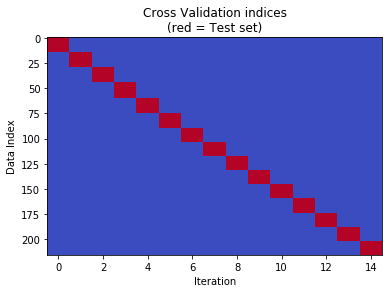

In [19]:
# Create the KFold object
from sklearn.model_selection import KFold
n_splits = 15
cv = KFold(n_splits=n_splits)

cv_sample = np.zeros([len(fmri_masked), n_splits])
for ii, (tr,tt) in enumerate(cv.split(fmri_masked)):
    cv_sample[tt, ii] = 1
fig, ax = plt.subplots()
ax.imshow(cv_sample, cmap='coolwarm', aspect='auto', interpolation='nearest')
_ = ax.set(xlabel='Iteration', ylabel='Data Index',
           title='Cross Validation indices\n(red = Test set)')

As you can see, on each iteration we hold out a different subset of samples. Next, we'll loop through this object, fit a model on one subset of data, and then test it on the other subset.

In [20]:
for train, test in cv.split(fmri_masked):
    svc.fit(fmri_masked[train], targets[train])
    prediction = svc.predict(fmri_masked[test])
    print(accuracy_score(targets[test], prediction))

1.0
0.533333333333
0.733333333333
0.733333333333
0.866666666667
0.866666666667
1.0
1.0
0.857142857143
0.928571428571
0.928571428571
0.428571428571
0.571428571429
0.357142857143
0.428571428571


If all we want to do is score this model, note that `sklearn` has tools to perform cross-validation more succinctly:

In [21]:
from sklearn.cross_validation import cross_val_score
cv_score = cross_val_score(svc, fmri_masked, targets)
print(cv_score)

[ 0.625       0.52777778  0.68055556]


/Users/choldgraf/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


> Note that we can speed things up to use all the CPUs of our computer
with the n_jobs parameter. However, be careful in doing this on a cluster environment as you may be asking for resources not available to you.

By default, cross_val_score uses a 3-fold KFold. We can control this by
passing the "cv" object, here a 5-fold:

In [22]:
cv_score = cross_val_score(svc, fmri_masked, targets,
                           cv=cv.split(fmri_masked))
print(cv_score)

[ 1.          0.53333333  0.73333333  0.73333333  0.86666667  0.86666667
  1.          1.          0.85714286  0.92857143  0.92857143  0.42857143
  0.57142857  0.35714286  0.42857143]


It's often useful to visualize these as a histogram, to get an idea for the distribution of cross-validated scores.

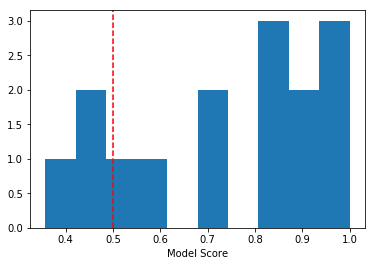

In [23]:
def plot_classifier_scores(scores):
    fig, ax = plt.subplots()
    ax.hist(scores)
    ax.axvline(.5, ls='--', c='r')
    ax.set_xlabel('Model Score')
plot_classifier_scores(cv_score)

### A quick note on cross-validating with time
As neuroscientists, our data is often collected across time. This might be across a very short time-scale (milliseconds) or a long one (hours, or days). Either way, it is crucial to consider the relationships between datapoints as a function of time. Consider the following facts:

* All time series data is correlated with itself (autocorrelated) to some degree
* Confounding variables may be the same on one day of acquisition, and different on another day
* The brain may have a different baseline internal state at the beginning of an experiment compared to the end.

As we've mentioned before, you must **always test the model on "new" data**. This means that the training and test sets should share as *little information as possible*. In other words, anything in the training set that could give you information about the test set, but that is not related to the features of interest, will **bias** the model towards the wrong answer, or inflate your model score.


## Leaving out recording sessions
The best way to do cross-validation is to respect the structure of
the experiment, for instance by leaving out full sessions of
acquisition.

The number of the session is stored in the CSV file with our
behavioral data. We'll apply our condition mask, and then leave out one session at a time. To do this, we'll use a LeaveOneLabelOut object:

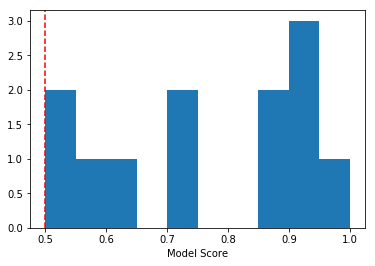

In [24]:
# Find out list of session number
session_label = labels['chunks'][condition_mask]

# Iterate through sessions, validating on a held-out session
from sklearn.cross_validation import LeaveOneLabelOut
cv = LeaveOneLabelOut(session_label)
cv_score = cross_val_score(svc, fmri_masked, targets, cv=cv)
plot_classifier_scores(cv_score)

## Inspecting the model weights


Finally, now that our model has been fit to data, and validated on held-out data, it may be useful to inspect and display the model weights. This is often used to understand the voxels that were particularly important in discriminating these two classes.

`sklearn` models that are linear store their weights in an attribute called `coef_`. We'll look at this below. Note that there is one weight per feature (in this case, voxels)

In [25]:
coef_ = svc.coef_
print(coef_[:5])

[[ -2.88744955e-02  -2.02894773e-02  -3.80503702e-02  -1.03376658e-02
   -7.92537092e-03   2.74215902e-02  -4.29658926e-02  -2.80413154e-02
   -8.59216548e-03  -3.41369866e-02  -8.29862419e-03  -5.18175050e-02
    4.43074303e-03   2.83813801e-02  -1.26069333e-02   3.04894441e-02
   -9.78554412e-03  -5.64672168e-02  -6.38488809e-02  -2.65693629e-02
    1.02342541e-02  -8.91423962e-03  -8.23235568e-03   6.91279848e-03
    2.09036678e-02   7.95128112e-03  -1.78697607e-02  -1.25507690e-02
   -3.01087554e-02   2.08279554e-02  -5.39096105e-02  -1.12495846e-02
    7.37854906e-03  -2.18180396e-02  -6.24465334e-02  -4.35288837e-02
   -8.86215119e-03   1.70283485e-02   6.30078955e-03   1.38651048e-03
   -3.03267039e-03  -4.57907213e-02   2.64653924e-02  -2.24597728e-02
    7.17317636e-04   4.67576001e-02  -4.18494614e-02  -3.47253699e-02
   -7.62794081e-03   1.28607433e-02  -2.06864154e-02  -3.73330214e-02
   -1.28567593e-02  -1.62821934e-02   4.36898626e-03  -1.25945124e-02
    2.99549069e-02  

In [26]:
print(svc.coef_.shape)
print(fmri_masked.shape)

(1, 577)
(216, 577)


### Turning the weights into a nifti image
Using our `NiftiMasker`, we can collect these weights and reshape them back into the 3-D space of our fMRI data.

We need to turn it back into a Nifti image, in essence, "inverting"
what the NiftiMasker has done.

For this, we can call inverse_transform on the NiftiMasker:

In [27]:
coef_img = masker.inverse_transform(coef_)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 40 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_f

coef_img is now a NiftiImage. Essentially, this is like the statistical "t-maps" that we've visualized before. 

We can save the coefficients as a nii.gz file:

In [28]:
coef_img.to_filename('haxby_svc_weights.nii.gz')

## Visualizing our weights

Finally, we can plot the weights that the model found, using the subject's anatomical as a background.

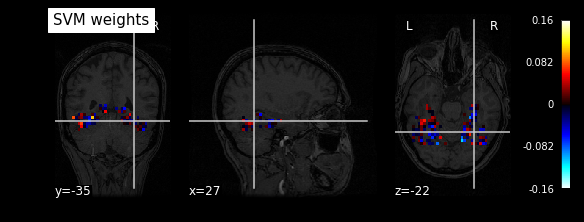

In [29]:
from nilearn.plotting import plot_stat_map, show

plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
              title="SVM weights")

# Recap
Above we've shown a sample pipeline for fitting a linear classifier using fMRI activity and object classes. We've covered a few of the basics in the machine learning pipeline, and shown how `nilearn` and `sklearn` complement one another.

Much more information about these functions, and the options available for machine learning, can be found in the `nilearn` documentation.